In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from functions import*
import matplotlib.pyplot as plt
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")
label = LoadCsvToList("g_1_der2_label.csv")
raw_hr_data = LoadCsvToList("g_1_der2.csv")


Using cuda for training.


In [2]:
label_lst = []
for i in range(len(raw_hr_data)):
    label_lst.append(0)
for i in label:
    label_lst[i] = 1
raw_hr_data = FilterLargeNum(raw_hr_data)


sdljflskdjflsdkjflsjdfj count_error = 0


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class WDCNN3(nn.Module):
    def __init__(self, first_kernel: int=64, n_classes: int=10) -> None:
        super(WDCNN3, self).__init__()
        self.conv_layers = nn.Sequential(
            #Conv1
            torch.nn.Conv1d(1, 16, first_kernel, stride=16, padding=24),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            #Pool1
            torch.nn.MaxPool1d(2, 2),
            #Conv2
            torch.nn.Conv1d(16, 32, 3, stride=1, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            #Pool2
            torch.nn.MaxPool1d(2, 2),
            #Conv3
            torch.nn.Conv1d(32, 32, 3, stride=1, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            #Pool3
            torch.nn.MaxPool1d(2, 2),
            #Conv4
            torch.nn.Conv1d(32, 32, 3, stride=1, padding=0),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            #Pool4
            torch.nn.MaxPool1d(2, 2)
        )

        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        self.linear_layers = nn.Sequential(
            torch.nn.Linear(32, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
        )
        self.head = torch.nn.Linear(100, n_classes)

        # self.reset_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)
        x = self.global_avg_pooling(x)
        # print(x.size())
        x = torch.flatten(x, 1)
        # print(x.size())
        x = self.linear_layers(x)
        x = self.head(x)
 
        return x

In [3]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention_weights_layer = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch, seq_len, hidden_dim]
        attention_weights = torch.softmax(self.attention_weights_layer(lstm_out).squeeze(2), dim=1)
        weighted_representation = torch.sum(lstm_out * attention_weights.unsqueeze(2), dim=1)
        output = self.fc(weighted_representation)
        return torch.sigmoid(output)


In [4]:
train_data = np.array(raw_hr_data[:80000])
train_labels = np.array(label_lst[:80000])
test_data = np.array(raw_hr_data[80000:])
test_labels = np.array(label_lst[80000:])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [5]:
# 데이터 준비 (가정: 데이터는 이미 분리되어 있음)
X_train = torch.tensor(train_data.reshape(-1, 1, 1), dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32)
X_test = torch.tensor(test_data.reshape(-1, 1, 1), dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

Epoch 1, Loss: 0.04279831796884537, Accuracy: 1.63%
Epoch 2, Loss: 0.012401035986840725, Accuracy: 1.63%
Epoch 3, Loss: 0.008638739585876465, Accuracy: 1.63%
Epoch 4, Loss: 0.017515381798148155, Accuracy: 1.63%
Epoch 5, Loss: 0.06121864914894104, Accuracy: 1.63%
Epoch 6, Loss: 0.004893116652965546, Accuracy: 1.63%
Epoch 7, Loss: 0.052665431052446365, Accuracy: 1.63%
Epoch 8, Loss: 0.024074574932456017, Accuracy: 1.63%
Epoch 9, Loss: 0.04952629283070564, Accuracy: 1.63%
Epoch 10, Loss: 0.03919107839465141, Accuracy: 1.63%
Epoch 11, Loss: 0.005939088761806488, Accuracy: 1.63%
Epoch 12, Loss: 0.13370667397975922, Accuracy: 1.63%
Epoch 13, Loss: 0.0037483617197722197, Accuracy: 1.63%
Epoch 14, Loss: 0.0003504157066345215, Accuracy: 1.63%
Epoch 15, Loss: 0.011924967169761658, Accuracy: 1.63%
Epoch 16, Loss: 0.00032605600426904857, Accuracy: 1.63%
Epoch 17, Loss: 0.01657205820083618, Accuracy: 1.63%
Epoch 18, Loss: 0.000727717240806669, Accuracy: 1.63%
Epoch 19, Loss: 0.0009067464852705598, 

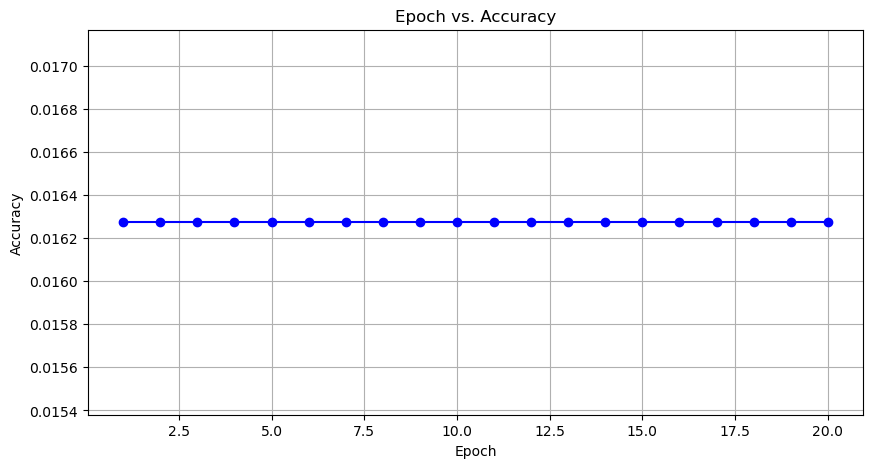

In [6]:
def train(model, data_loader, loss_fn, optimizer, epochs):
    model.to(device)
    accuracy_stats = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            # 예측 결과를 0과 1로 변환 (임계값 0.5 적용)
            predicted = torch.round(torch.sigmoid(y_pred))
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        
        epoch_accuracy = correct / total
        accuracy_stats.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {epoch_accuracy * 100:.2f}%")
    
    return accuracy_stats

# 모델 정의 및 훈련 파라미터 설정
# model = AttentionModel(input_dim=1, hidden_dim=30, output_dim=1)
model = WDCNN3()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()
epochs = 20

# 훈련 함수 호출
accuracy_stats = train(model, train_loader, loss_fn, optimizer, epochs)

# 에포크별 정확도 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), accuracy_stats, marker='o', linestyle='-', color='b')
plt.title("Epoch vs. Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [19]:
def evaluate_and_predict(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred.squeeze(), y_batch)
            total_loss += loss.item()
            predicted = (y_pred.squeeze() > 0.40).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_predictions.extend(predicted.tolist())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy, all_predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is on the correct device
test_loss, test_accuracy, predicted_labels = evaluate_and_predict(model, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print("Predicted labels:", predicted_labels)


Test Loss: 0.0192, Test Accuracy: 0.9912
Predicted labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [20]:
cnt = 0
tmp_lst = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0:
        cnt+=1
    else :
        tmp_lst.append(i)
print(cnt,len(predicted_labels))
new_tmp_lst = []
for i in tmp_lst:
    new_tmp_lst.append(i+80000)

37950 38659


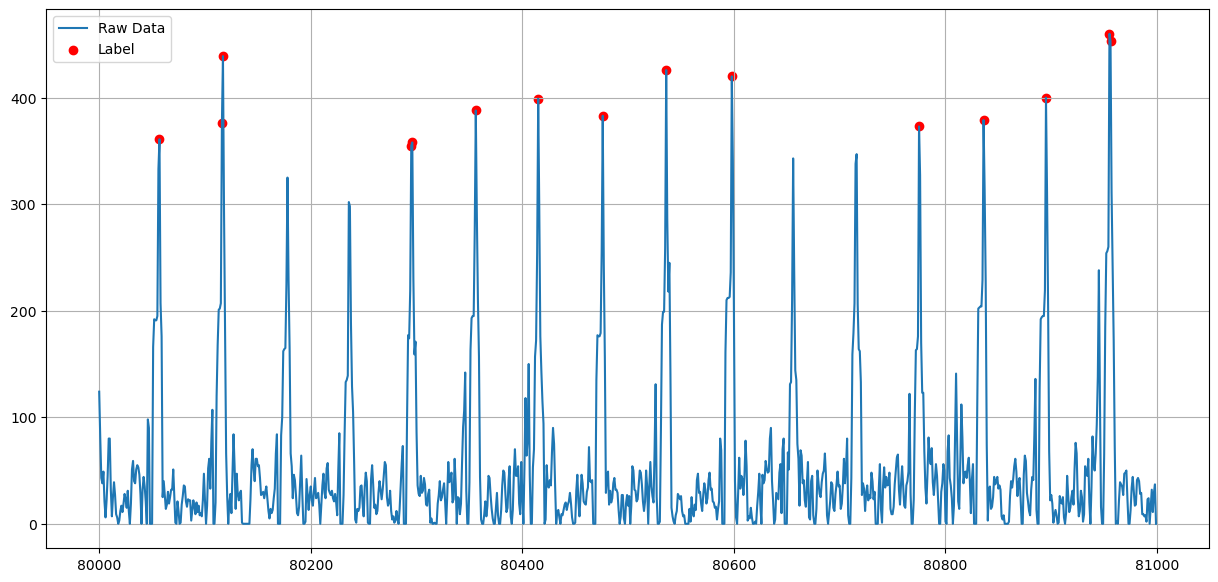

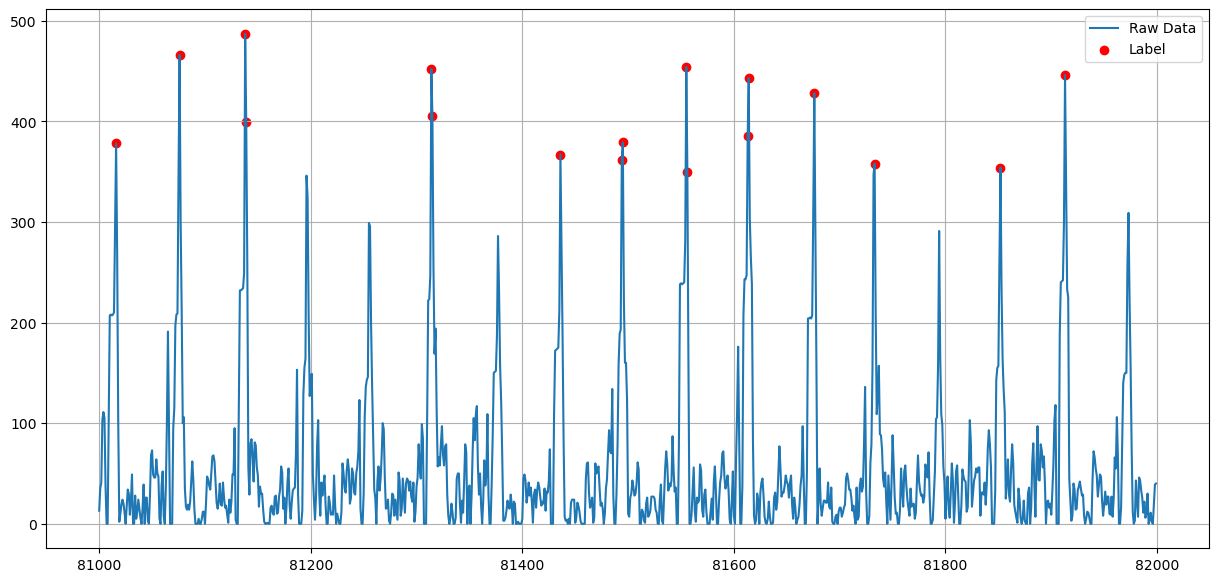

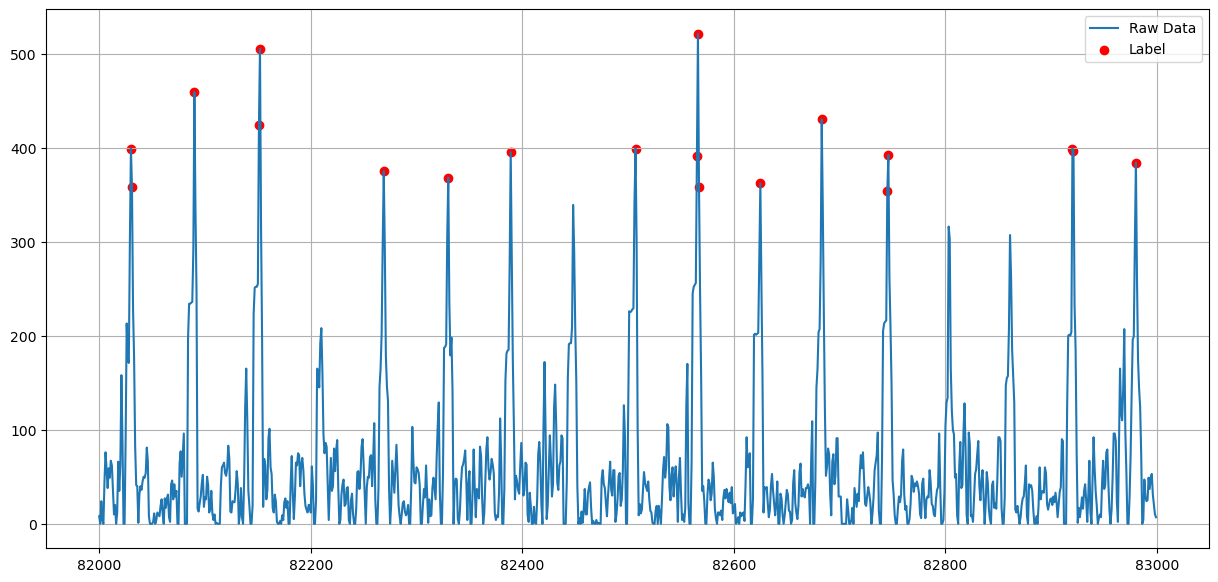

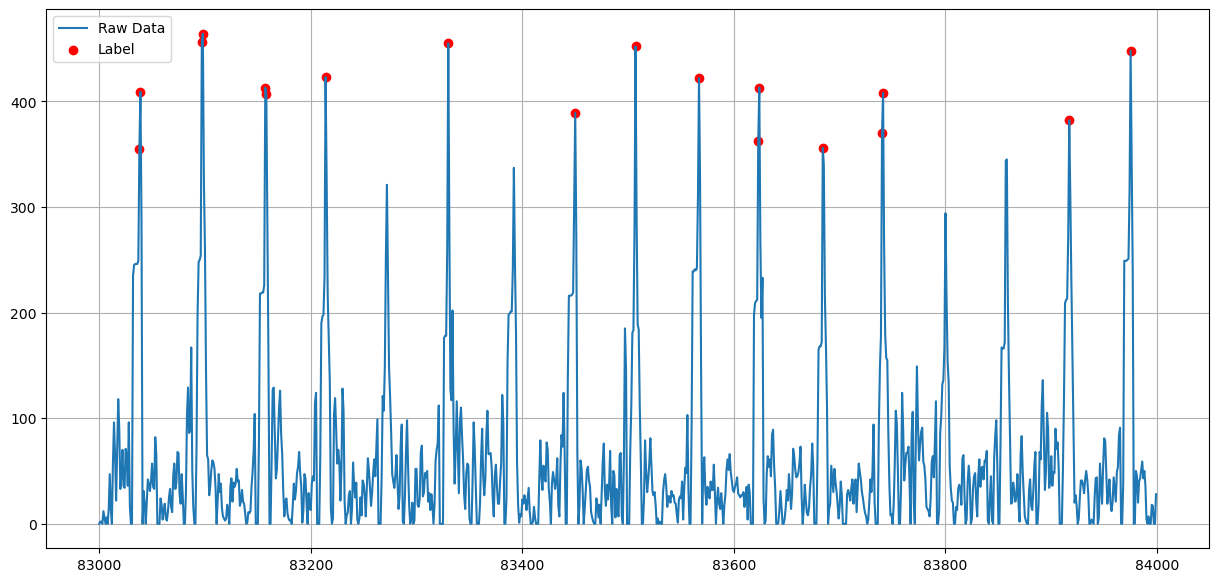

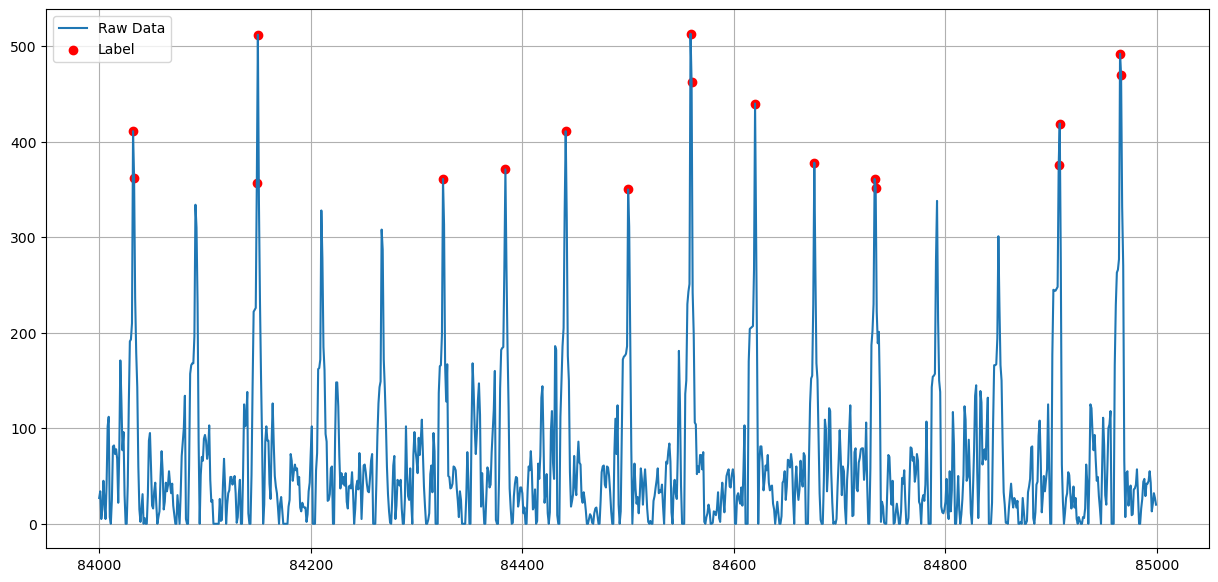

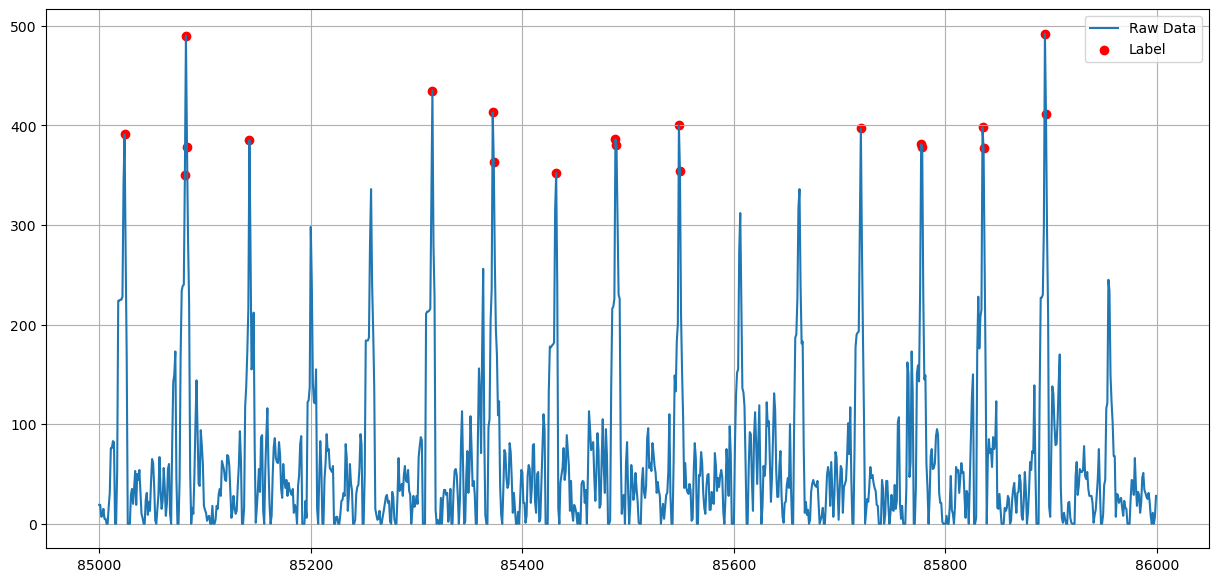

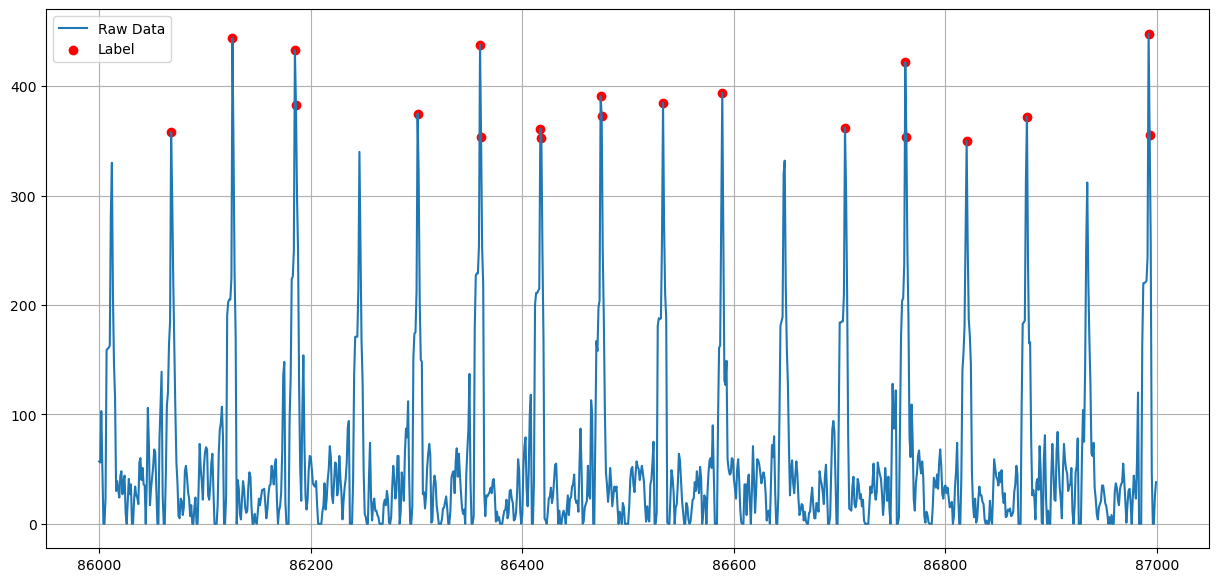

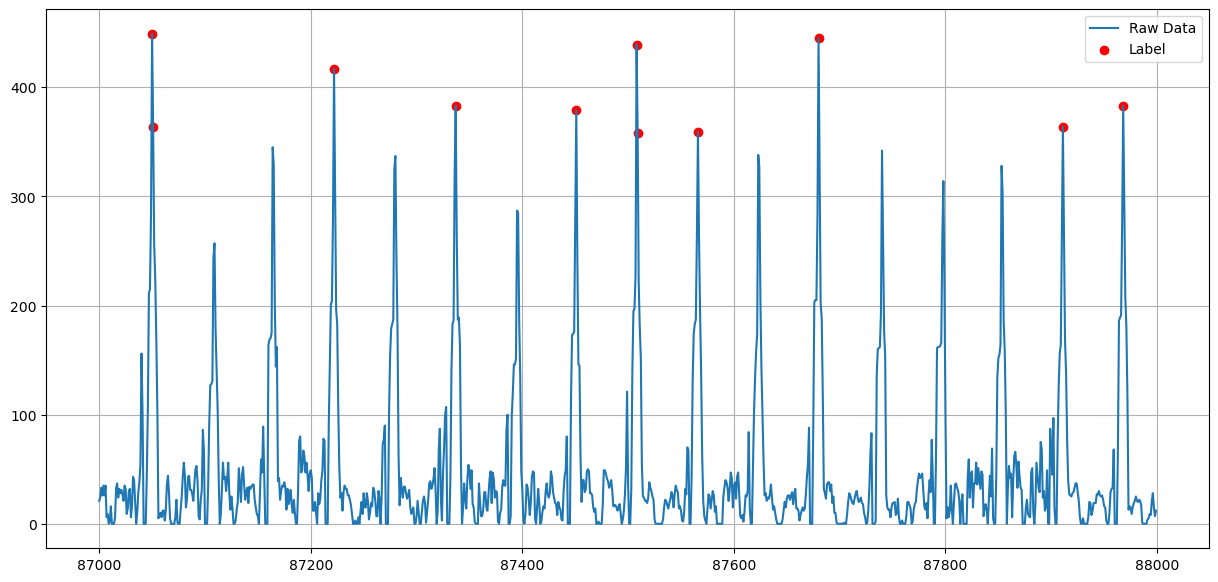

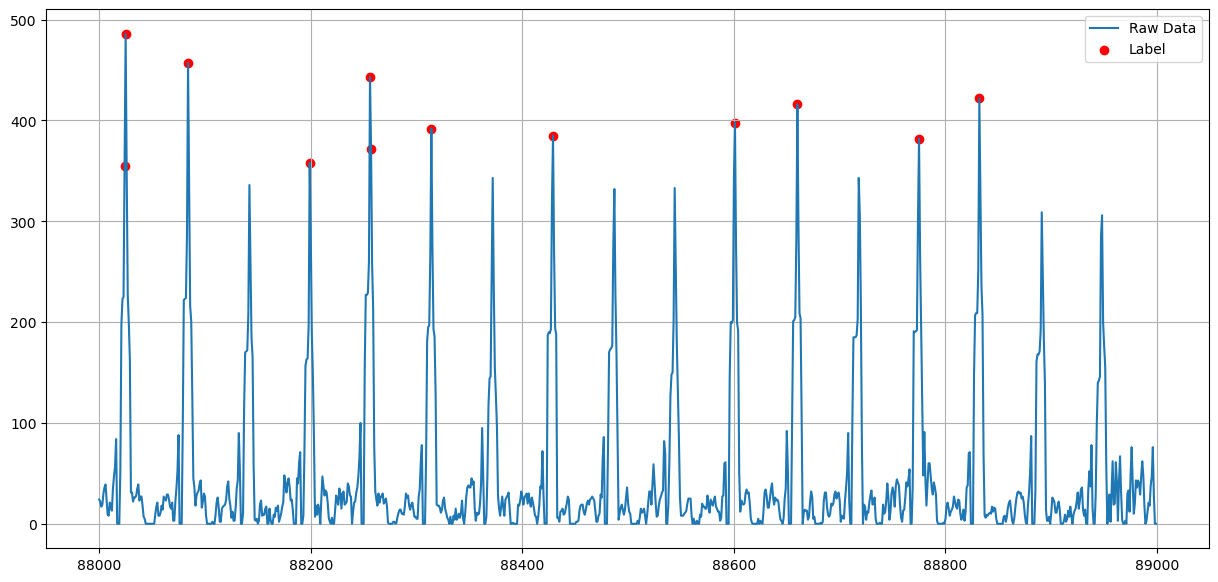

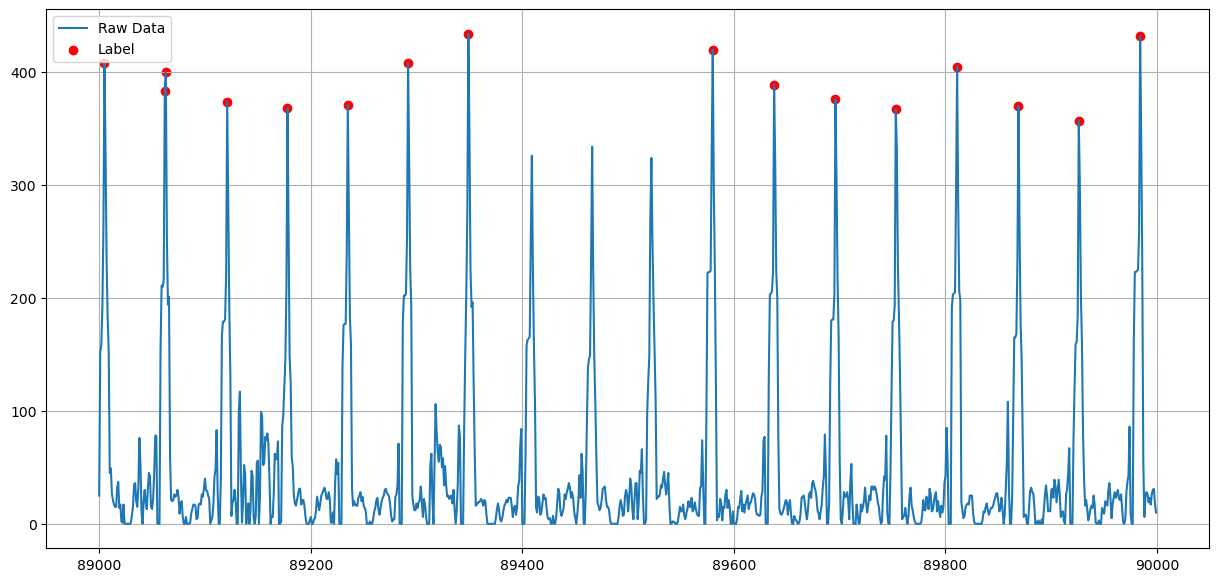

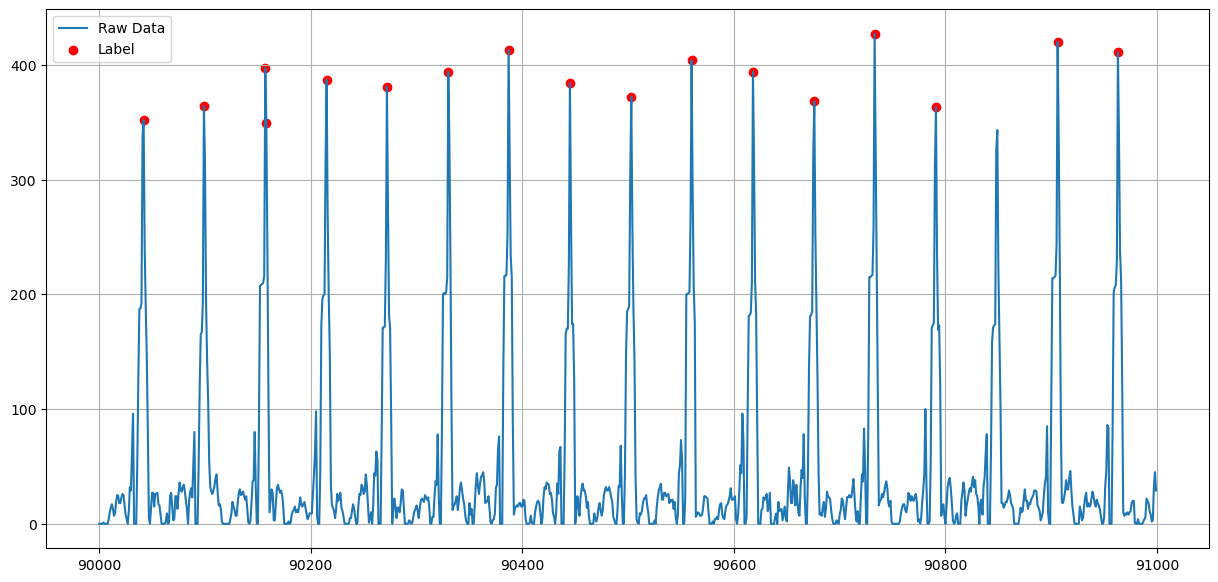

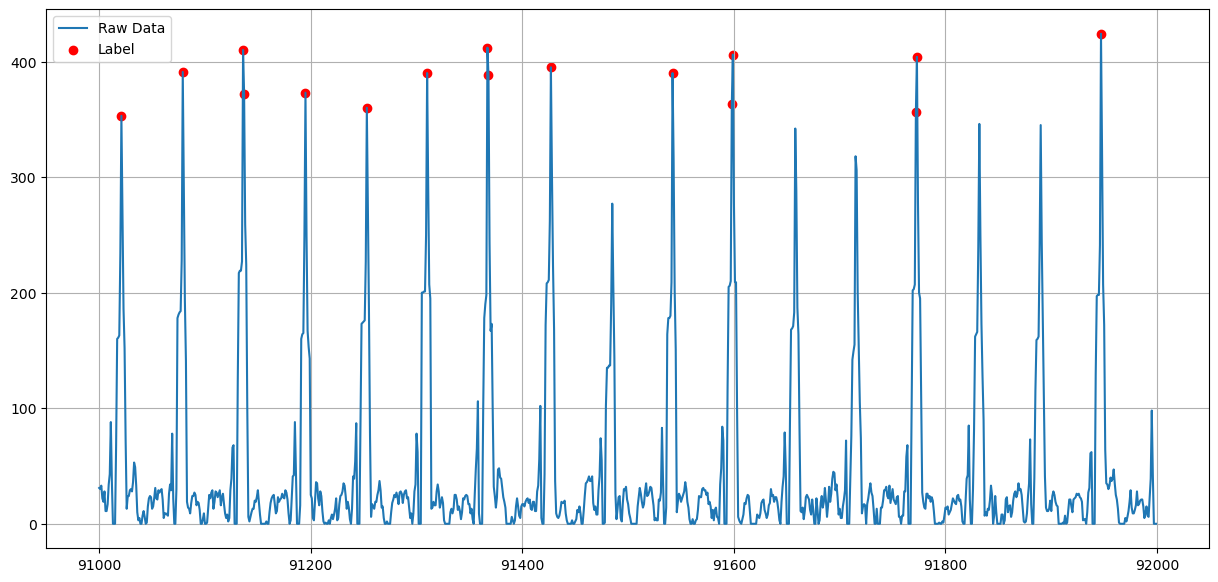

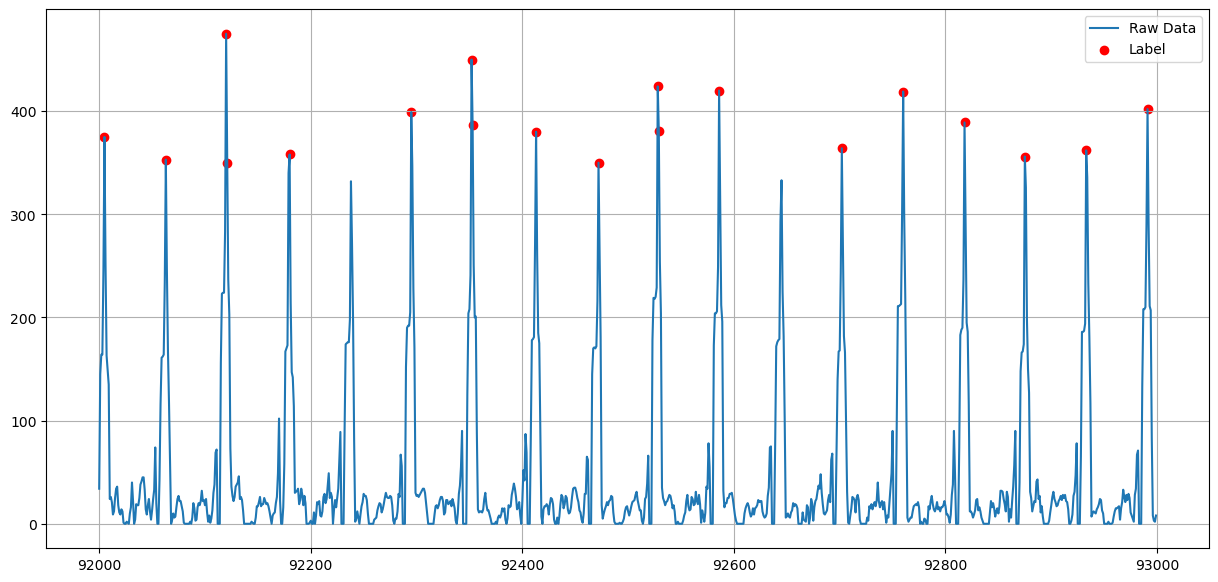

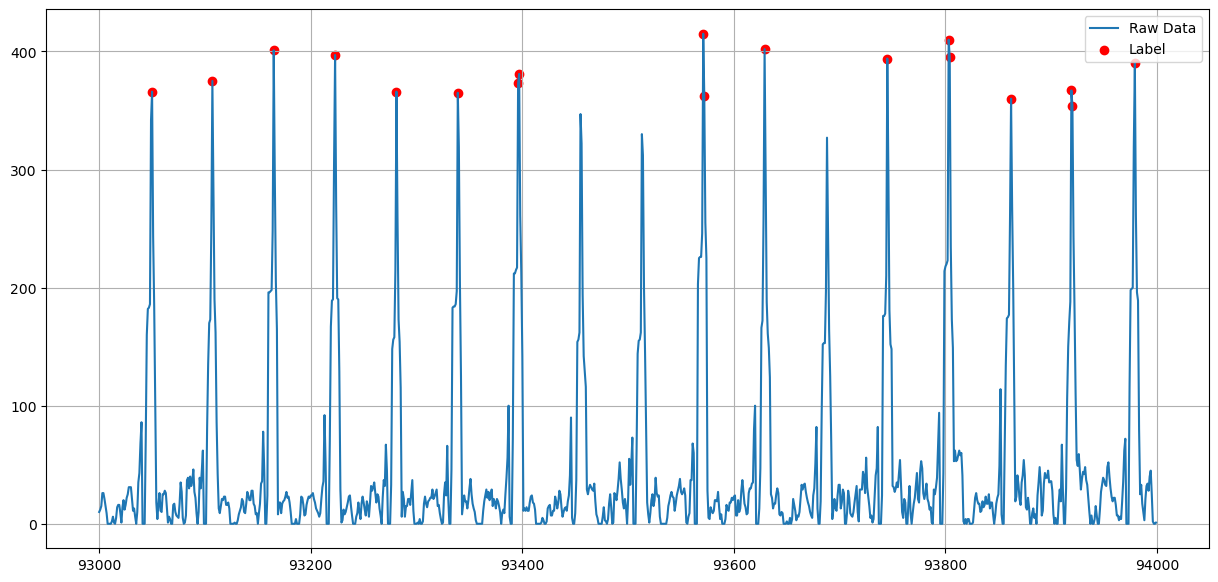

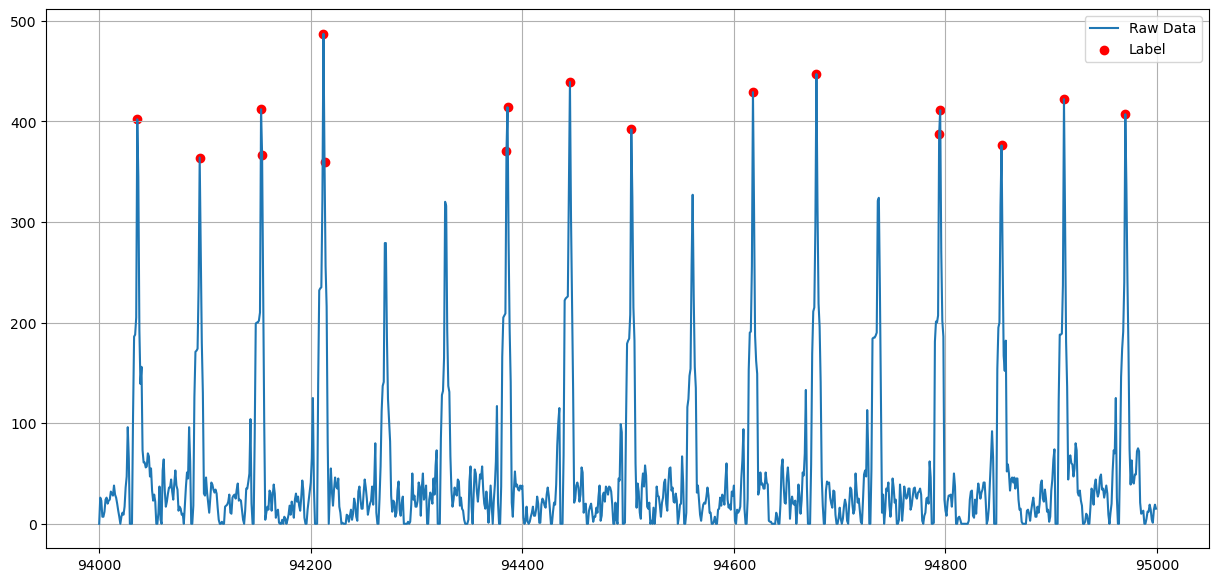

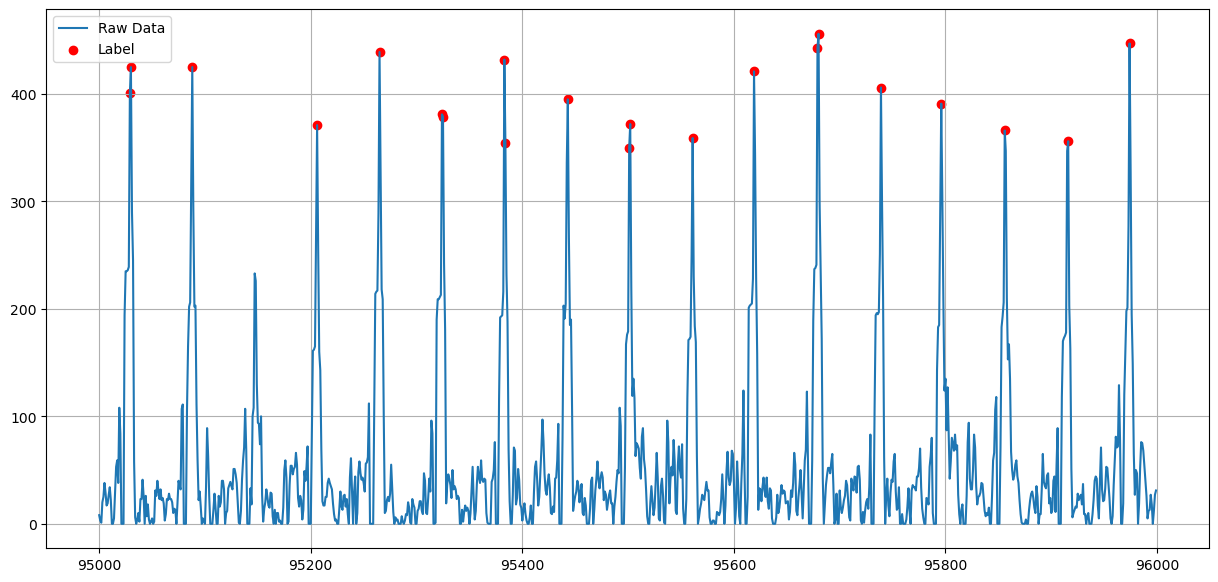

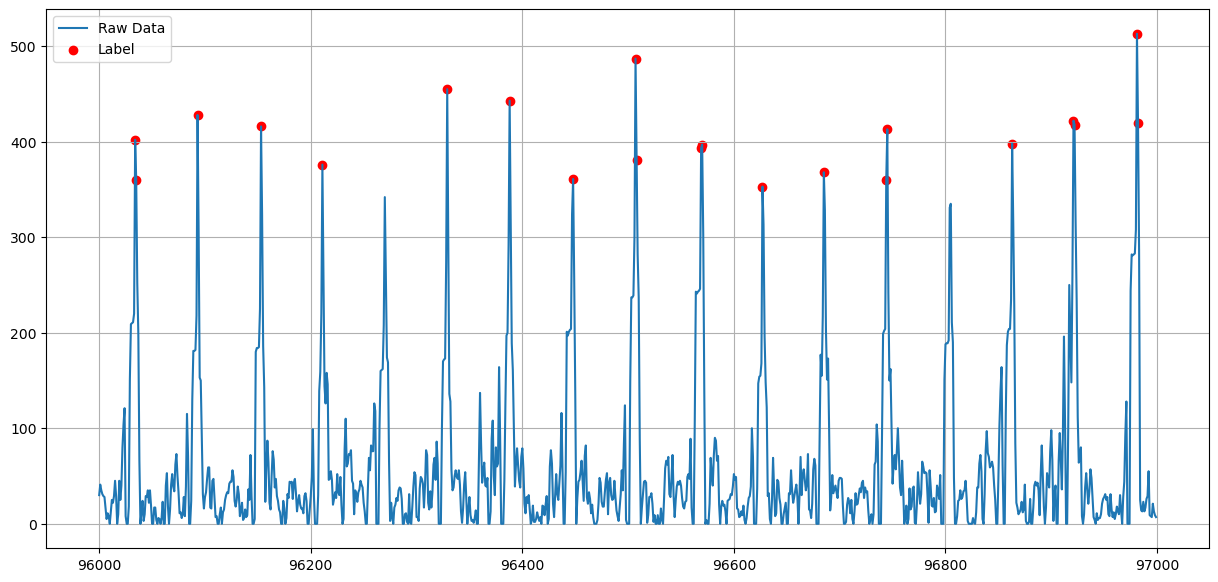

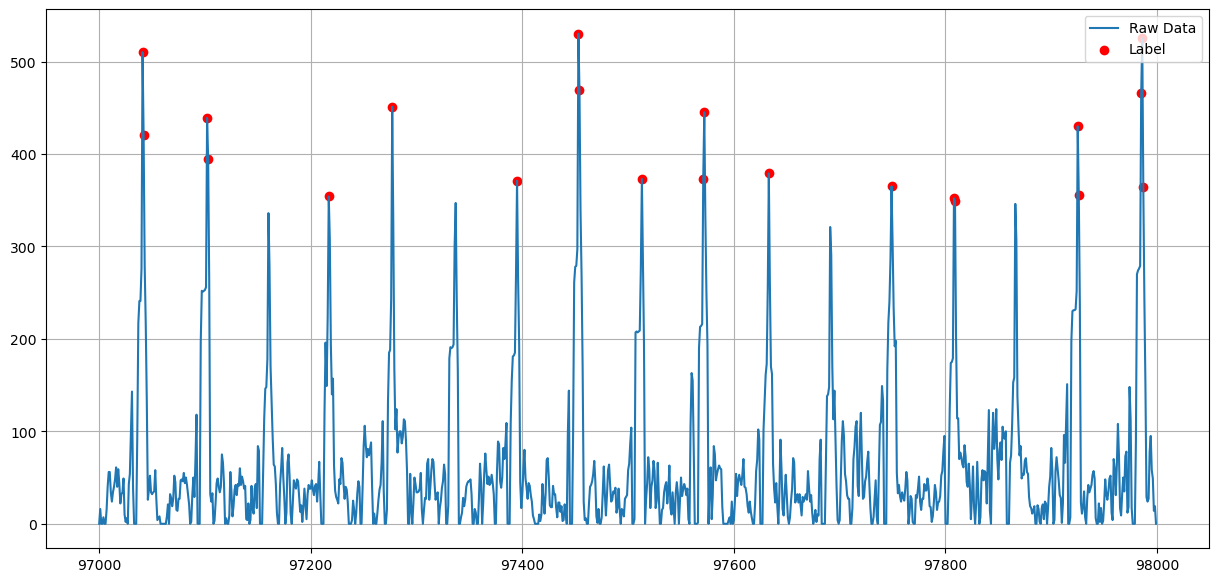

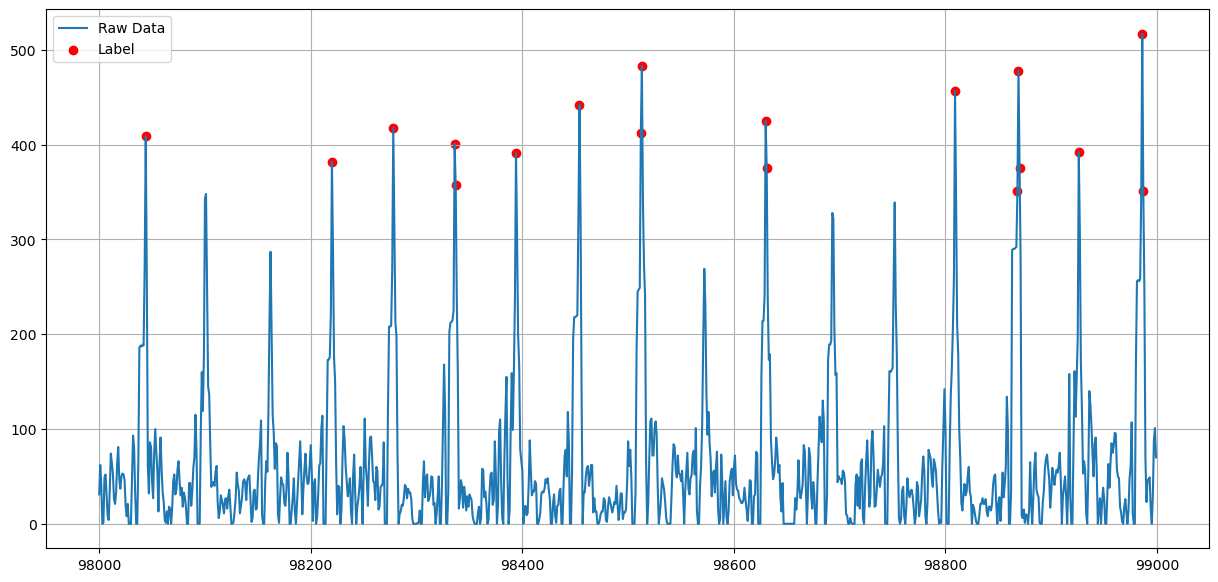

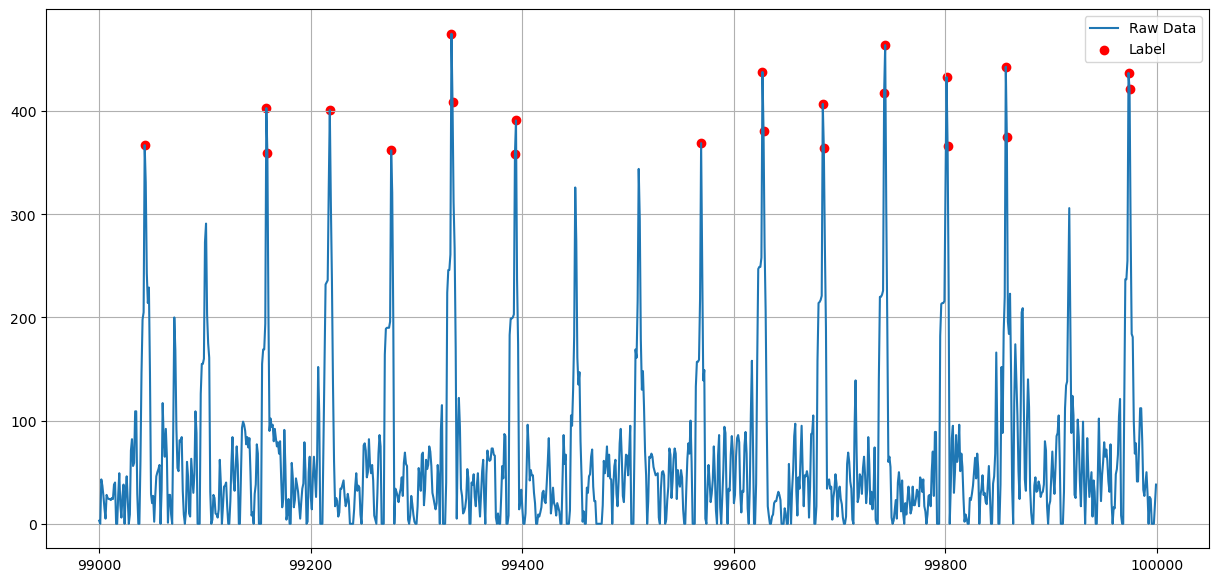

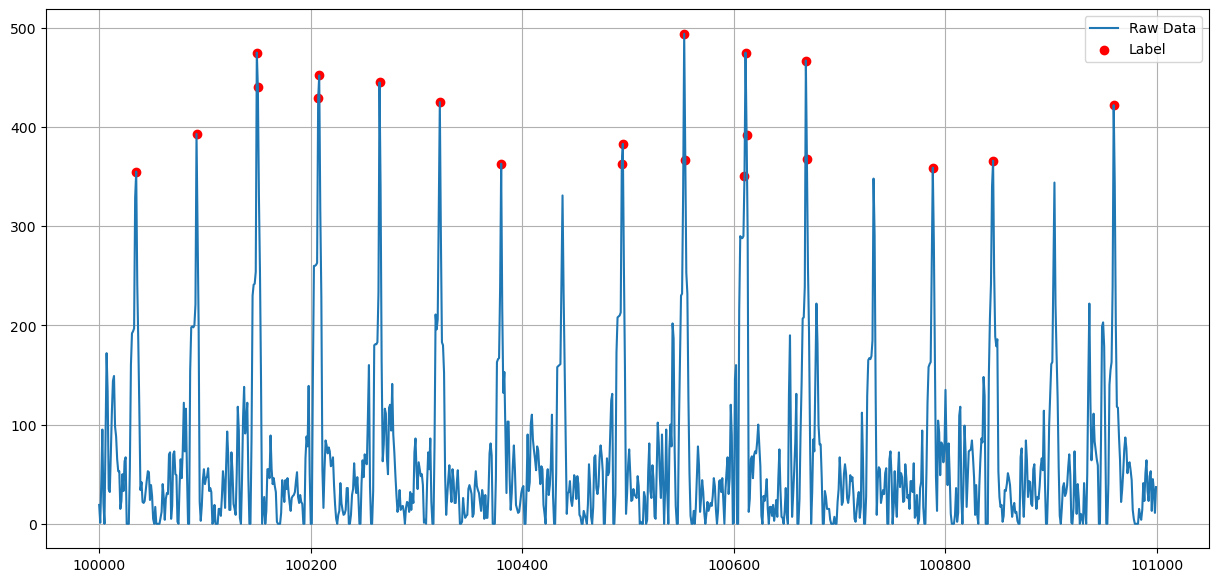

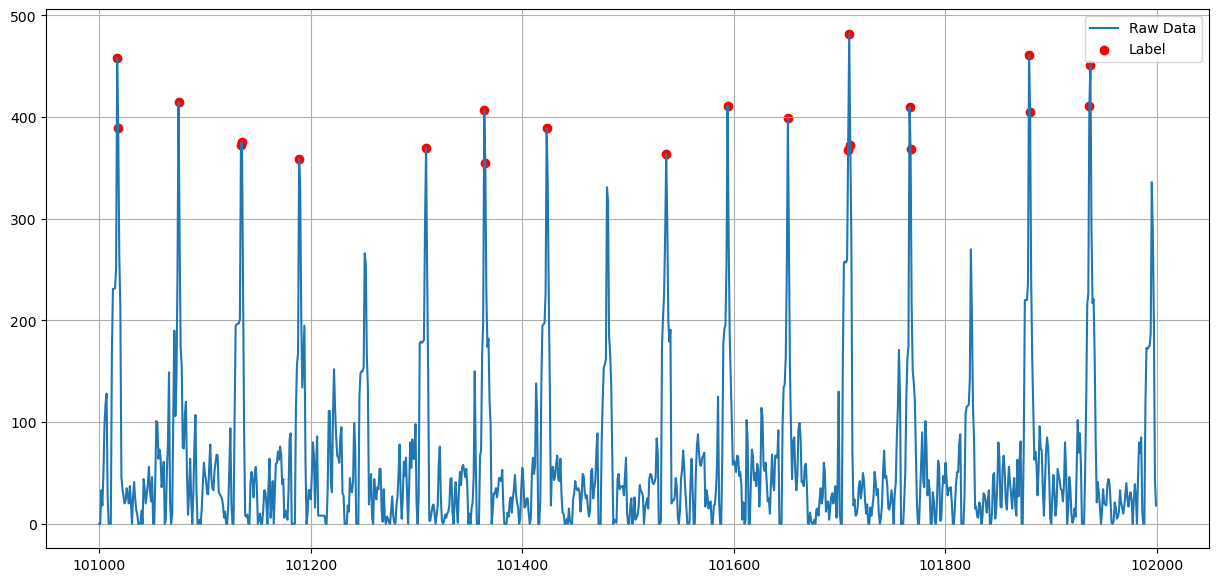

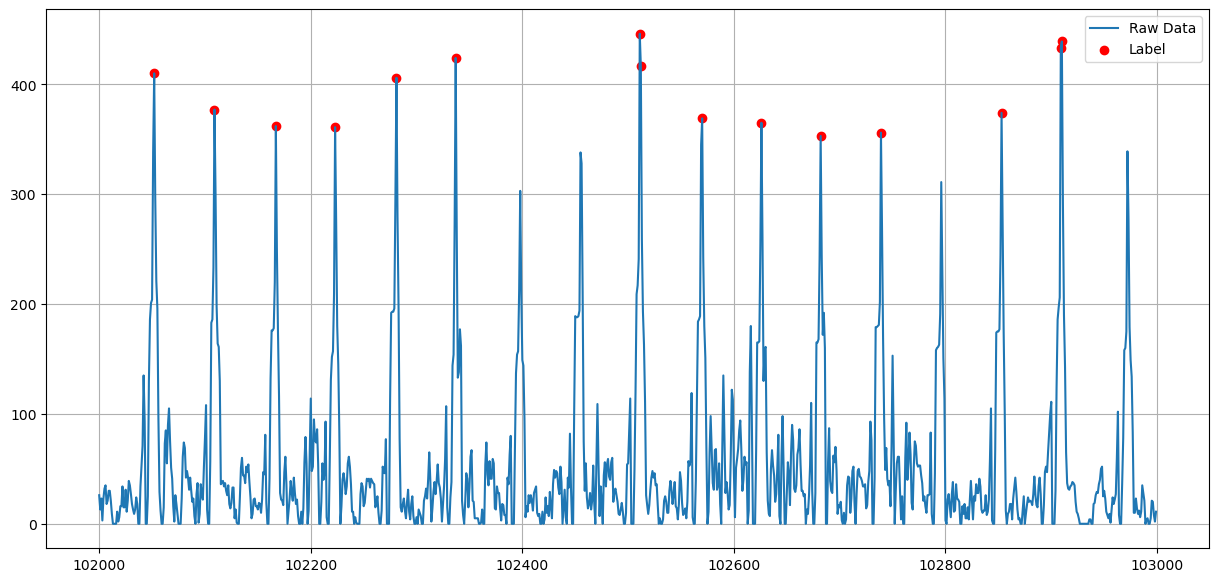

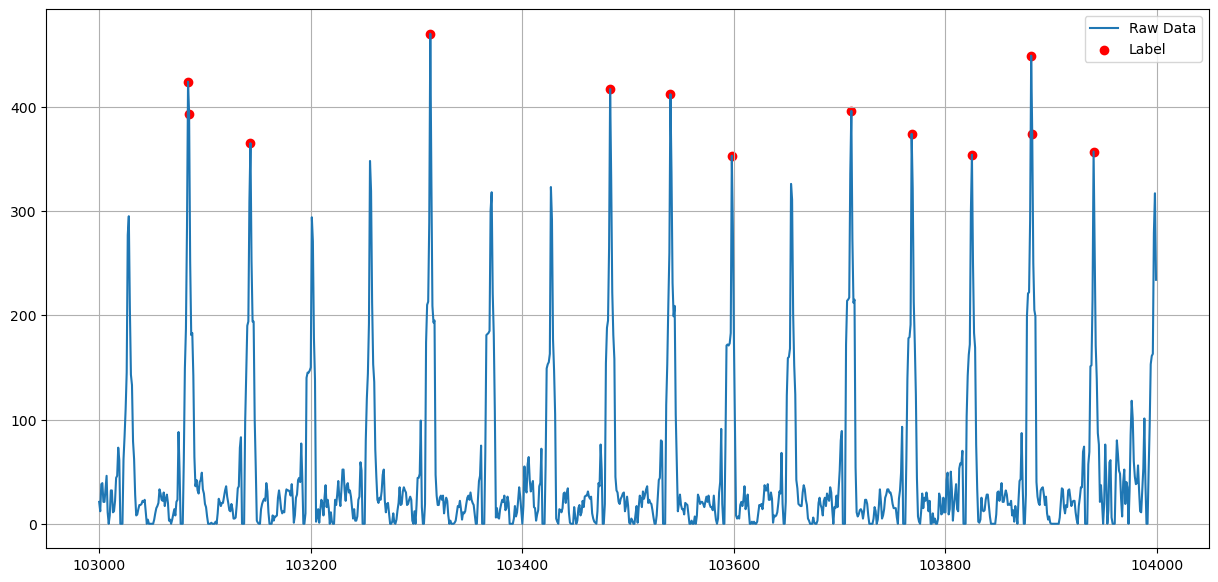

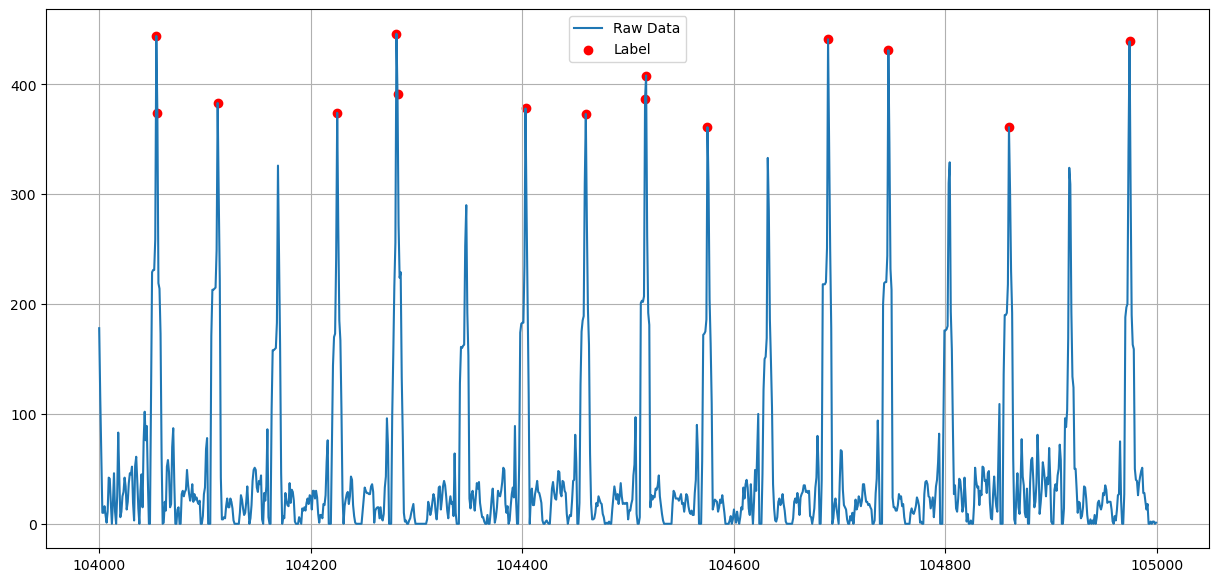

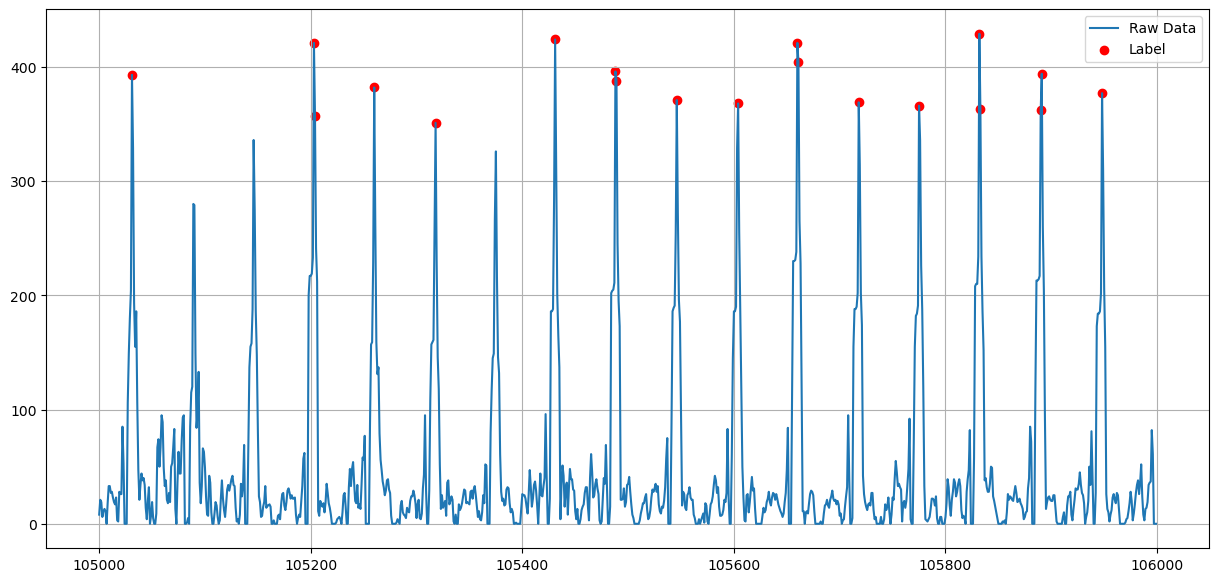

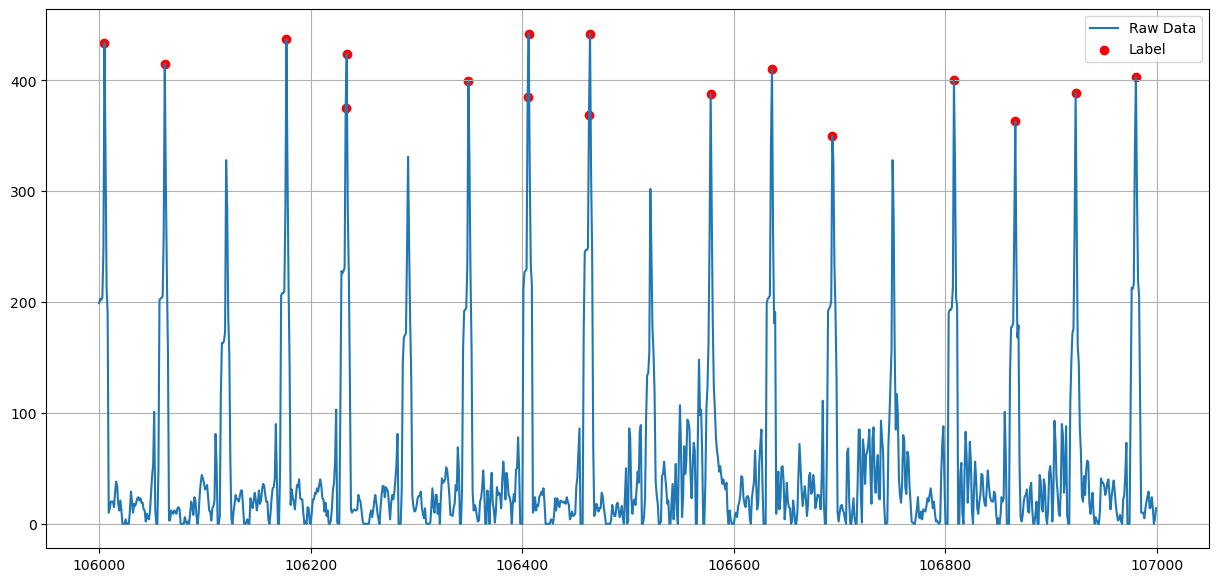

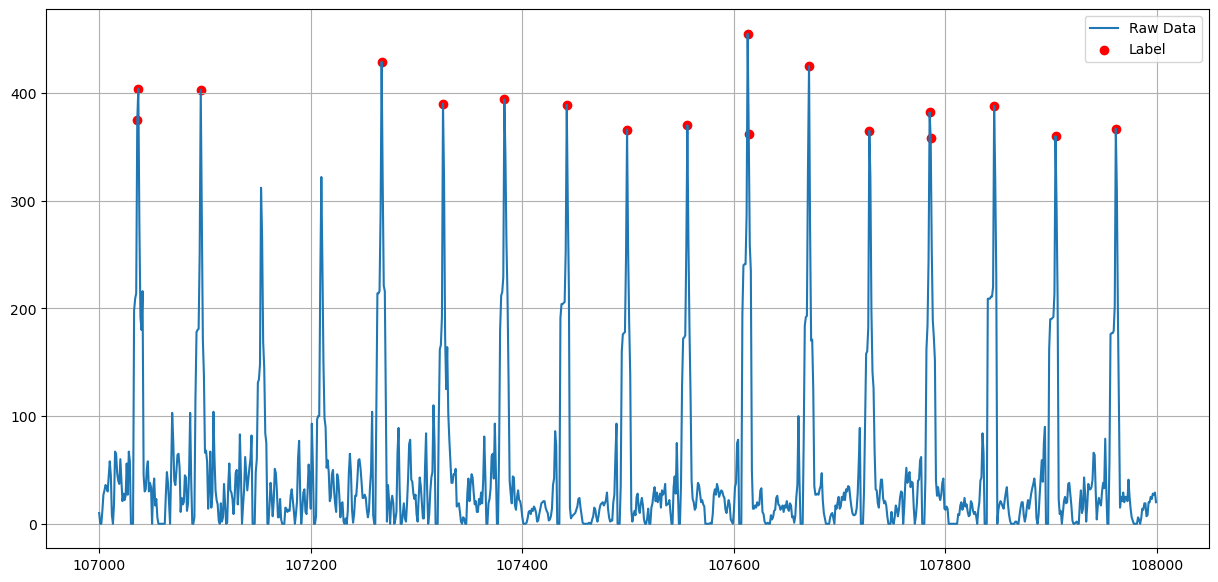

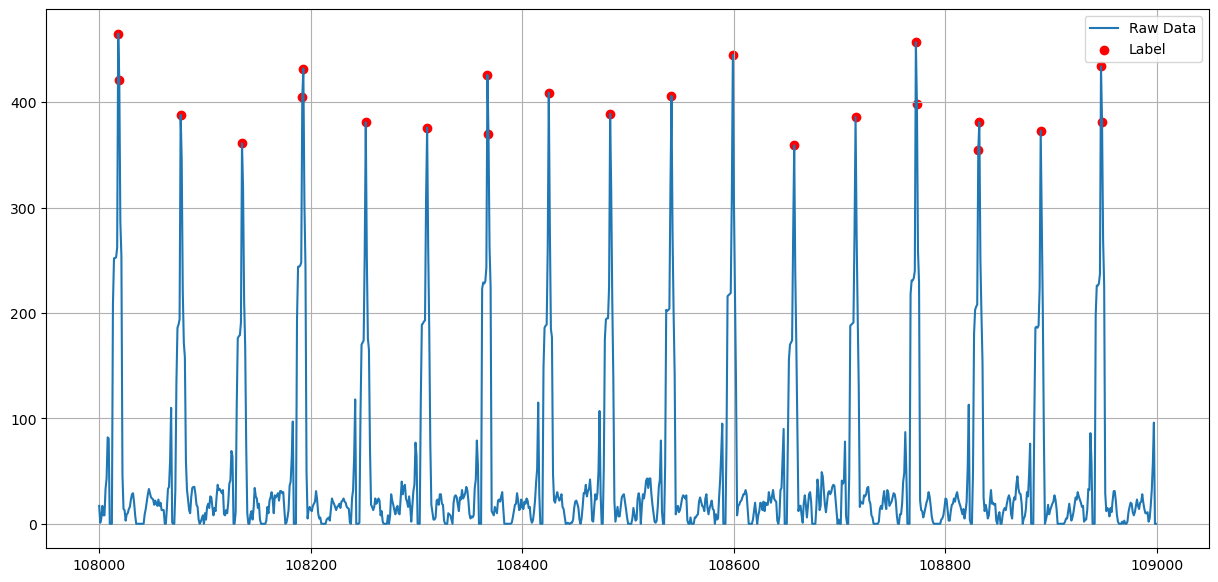

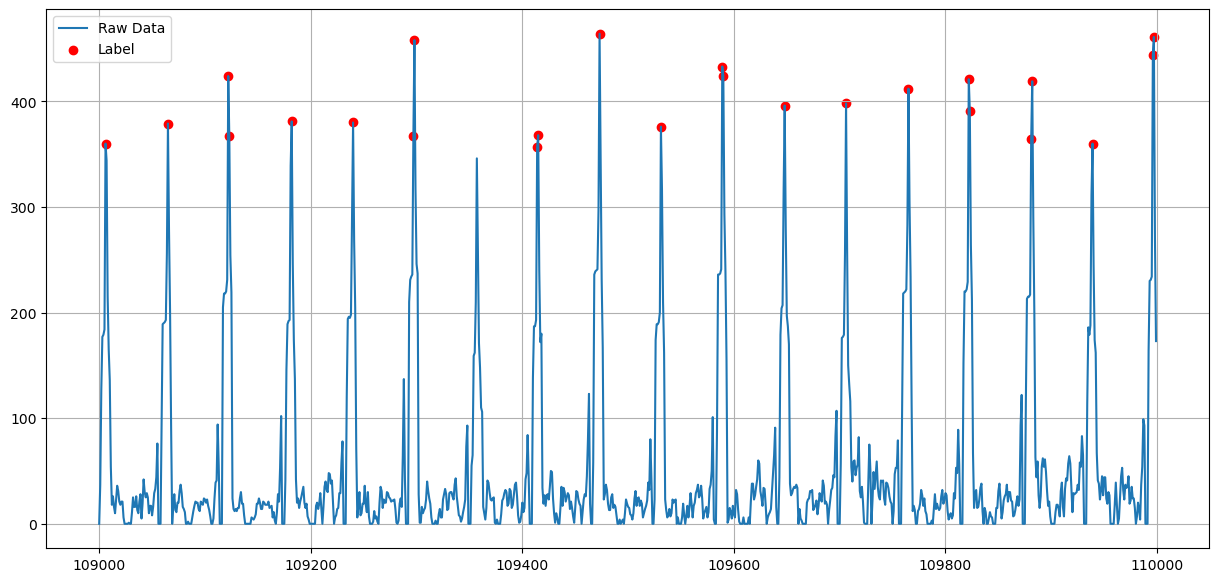

In [21]:
for i in range(30):
    ShowLabelList(raw_hr_data,new_tmp_lst,80000+1000*i)

In [13]:
new_raw_hr_data = LoadCsvToList("m_1.csv")